Part 1 - Data Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
# Importing the training set
dataset_ts = pd.read_csv('/content/drive/MyDrive/Datasets/AusGas.csv')

dataset_ts.head()

,Month,GasProd
0,Jan-1956,1709
1,Feb-1956,1646
2,Mar-1956,1794
3,Apr-1956,1878
4,May-1956,2173


In [3]:
dataset_ts.shape

(476, 2)

In [4]:
dataset_train = dataset_ts.iloc[:450,:]
dataset_train.shape

(450, 2)

In [5]:
training_set = dataset_train.iloc[:, 1].values
training_set[:5]

array([1709, 1646, 1794, 1878, 2173])

In [6]:
training_set.shape

(450,)

Feature Scaling

In [7]:
training_set = training_set.reshape(-1,1)
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [8]:
training_set.shape

(450, 1)

In [9]:
training_set_scaled[:5]

array([[0.00103697],
       [0.        ],
       [0.00243605],
       [0.00381868],
       [0.00867433]])

Creating a data structure with timesteps and 1 output

In [10]:
timesteps=10
trn_size = dataset_train.shape[0]

In [11]:
X_train = []
y_train = []
for i in range(timesteps, trn_size):
    X_train.append(training_set_scaled[i-timesteps:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)


In [12]:
X_train.shape

(440, 10)

In [13]:
X_train[:1]

array([[0.00103697, 0.        , 0.00243605, 0.00381868, 0.00867433,
        0.01111038, 0.01352997, 0.01267406, 0.00885538, 0.00781842]])

In [14]:
y_train[:1]

array([0.0052013])

In [15]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [16]:
X_train.shape

(440, 10, 1)

Part 2 - Building the RNN

In [17]:
import tensorflow as tf
from tensorflow import keras

In [18]:
(X_train.shape[1],X_train.shape[2])

(10, 1)

Initialising the RNN

In [19]:
tf.random.set_seed(seed=2021)
model = keras.Sequential([
   tf.keras.layers.LSTM(units=100,return_sequences = True, 
                            input_shape= (X_train.shape[1],X_train.shape[2]) ),
   tf.keras.layers.LSTM(units=70,return_sequences = True ) ,
   tf.keras.layers.LSTM(units=50 ) ,
   tf.keras.layers.Dense(1)                           
])
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.add(keras.layers.LSTM(units=100,return_sequences = True, 
                            input_shape= (X_train.shape[1],X_train.shape[2]) ))
model.add(keras.layers.LSTM(units=70,return_sequences = True ))
model.add(keras.layers.LSTM(units=50 ))

model.add(keras.layers.Dense(1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 10, 70)            47880     
                                                                 
 lstm_2 (LSTM)               (None, 50)                24200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 112,931
Trainable params: 112,931
Non-trainable params: 0
_________________________________________________________________


Fitting the RNN to the Training set

In [21]:
model.fit(X_train, y_train, epochs = 50, batch_size = 25)

Epoch 1/50
18/18 [==============================] - 9s 16ms/step - loss: 0.0525
Epoch 2/50
18/18 [==============================] - 0s 15ms/step - loss: 0.0103
Epoch 3/50
18/18 [==============================] - 0s 16ms/step - loss: 0.0088
Epoch 4/50
18/18 [==============================] - 0s 15ms/step - loss: 0.0079
Epoch 5/50
18/18 [==============================] - 0s 16ms/step - loss: 0.0075
Epoch 6/50
18/18 [==============================] - 0s 16ms/step - loss: 0.0076
Epoch 7/50
18/18 [==============================] - 0s 15ms/step - loss: 0.0071
Epoch 8/50
18/18 [==============================] - 0s 16ms/step - loss: 0.0076
Epoch 9/50
18/18 [==============================] - 0s 16ms/step - loss: 0.0074
Epoch 10/50
18/18 [==============================] - 0s 16ms/step - loss: 0.0072
Epoch 11/50
18/18 [==============================] - 0s 15ms/step - loss: 0.0076
Epoch 12/50
18/18 [==============================] - 0s 15ms/step - loss: 0.0071
Epoch 13/50
18/18 [==================

Part 3 - Making the predictions and visualising the results

In [22]:
dataset_test = dataset_ts.iloc[450:,:]
dataset_test.shape

(26, 2)

In [23]:
test_set = dataset_test.iloc[:, 1].values
test_set

array([56807, 54634, 51367, 48073, 46251, 43736, 39975, 40478, 46895,
       46147, 55011, 57799, 62450, 63896, 57784, 53231, 50354, 38410,
       41600, 41471, 46287, 49013, 56624, 61739, 66600, 60054])

In [24]:
dataset_total = pd.concat((dataset_train['GasProd'], dataset_test['GasProd']), axis = 0)
dataset_total

0       1709
1       1646
2       1794
3       1878
4       2173
       ...  
471    49013
472    56624
473    61739
474    66600
475    60054
Name: GasProd, Length: 476, dtype: int64

In [25]:
inputs = dataset_total[len(dataset_total) - len(dataset_test) - timesteps:].values
inputs = inputs.reshape(-1,1)
len(inputs)

36

In [26]:
inputs = sc.transform(inputs)
X_test = []
for i in range(timesteps, len(inputs)):
    X_test.append(inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(26, 10, 1)

In [27]:
predicted_values = model.predict(X_test)
predicted_values

array([[0.95648646],
       [0.9465517 ],
       [0.8532172 ],
       [0.7361259 ],
       [0.6432518 ],
       [0.60328025],
       [0.5951632 ],
       [0.6228335 ],
       [0.65574646],
       [0.7418416 ],
       [0.79913294],
       [0.8825216 ],
       [0.9315182 ],
       [0.94930923],
       [0.93021905],
       [0.8398452 ],
       [0.7395553 ],
       [0.68505514],
       [0.5997851 ],
       [0.5822381 ],
       [0.6315495 ],
       [0.7373555 ],
       [0.8596857 ],
       [0.974172  ],
       [1.0226202 ],
       [1.0231729 ]], dtype=float32)

In [28]:
predicted_values.shape

(26, 1)

In [29]:
predicted_values = sc.inverse_transform(predicted_values)
predicted_values

array([[59756.38 ],
       [59152.8  ],
       [53482.355],
       [46368.594],
       [40726.117],
       [38297.688],
       [37804.547],
       [39485.625],
       [41485.223],
       [46715.848],
       [50196.523],
       [55262.72 ],
       [58239.457],
       [59320.332],
       [58160.527],
       [52669.953],
       [46576.94 ],
       [43265.84 ],
       [38085.344],
       [37019.293],
       [40015.156],
       [46443.293],
       [53875.348],
       [60830.844],
       [63774.266],
       [63807.84 ]], dtype=float32)

Visualising the results

In [30]:
%matplotlib inline

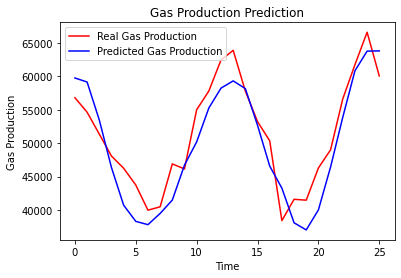

In [31]:
plt.plot(test_set, color = 'red', label = 'Real Gas Production')
plt.plot(predicted_values, color = 'blue', label = 'Predicted Gas Production')
plt.title('Gas Production Prediction')
plt.xlabel('Time')
plt.ylabel('Gas Production')
plt.legend()
plt.show()

Root Mean Square Error

In [32]:
print(np.sqrt(mean_squared_error(predicted_values,test_set)))

3653.3847089852134
